#-----------------------------------------------THE RELM---------------------------------

## REINFORCEMENT EVOLUTIONARY LEARNING METHOD

#### WE BREAK THE PARADIM OF MODEL MAINTENANCE DUE TO CONCEPT DRIFT BY COMBINING REINFORCEMENT LEARNING AUGMENTED WITH GENETIC ALGORITHM - FOR REGULAR CLASSIFICATION MODEL 

### CONNECT TO GOOGLE DRIVE - AUTHORIZATION- MOUNT DRIVE AS LOCAL DRIVE FOR COLAB

In [0]:
! pip install psutil
import psutil

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### LET'S GET THE DATA LOADED DIRECTLY FROM GOOGLE DRIVE

In [0]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/RELM/creditcard_fraud_kaggle_data.csv',encoding='latin-1')

In [0]:
df.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [0]:
LOCATION= '/content/gdrive/My Drive/RELM'

### NEED TO INSTALL HARDMARU'S EVOLUTION STRATEGY IMPLEMENTATION- DIRECTLY FROM GIT

In [0]:
!pip install git+https://github.com/hardmaru/estool.git

  Cloning https://github.com/hardmaru/estool.git to /tmp/pip-req-build-l9y884cd
  Running setup.py bdist_wheel for estool ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-74mdxrkn/wheels/b3/e4/b6/303c18e1abda6dcb1a64f5ab643ce2333e24ca38b748debb80
Successfully built estool


In [0]:
!pip install numba

    100% |████████████████████████████████| 3.2MB 7.6MB/s 
    100% |████████████████████████████████| 16.1MB 1.9MB/s 


In [0]:
# this would be required in hardmaru's code 
!pip install cma

    100% |████████████████████████████████| 225kB 6.8MB/s 


### Let's import some libraries which might be required

In [0]:
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import pandas as pd
import sys

In [0]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
import time
import copy
from collections import namedtuple
import concurrent.futures
from numba import jit,njit,prange
import pickle

# EA imports
from es import SimpleGA, PEPG, CMAES, OpenES

# for evaluation and fitness
from sklearn.metrics import accuracy_score,auc,f1_score,hinge_loss,cohen_kappa_score,log_loss,adjusted_mutual_info_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve,confusion_matrix,roc_auc_score
from sklearn.metrics.regression import r2_score,mean_squared_error,mean_absolute_error,explained_variance_score
from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## PARALLEL PROCESSING BLOCK- NOt used

In [0]:
import time
import multiprocessing


class Parallelize(object):

    def __init__(self, func, func_params, processes=-1, split_data=True, agg_func=None, agg_func_params=None,
                 func_exec_text=None, split_eval_func=None, timer=True, verbose=False):

        self.func = func
        self.func_params = func_params
        if processes == -1:
            cpu_units = multiprocessing.cpu_count() * 2
            self.processes = cpu_units if cpu_units < 8 else 8
        else:
            self.processes = processes

        self.data = None
        self.split_data = split_data
        self.data_list = []
        self.outputs = []

        self.agg_func = agg_func
        self.agg_func_params = agg_func_params

        self.func_exec_text = func_exec_text
        self.split_eval_func = split_eval_func
        self.timer = timer
        self.verbose = verbose

    def _data_splitter(self, data):

        if len(self.data_list) != 0:
            print('There are {} splits available. Removing them!'.format(len(self.data_list)))
            del self.data_list
            self.data_list = []

        if self.split_data:

            for l in np.array_split(data, self.processes):
                if self.verbose:
                    print('Split Shape: {}'.format(l.shape))
                if self.split_eval_func is not None:
                    print('Split Evaluation:')
                    self.split_eval_func(l)

                self.data_list.append(l)

            assert len(self.data_list) == self.processes

        else:

            self.data_list = [data]

            assert len(self.data_list) == 1

    def _processor(self, sub_data):

        output = self.func(sub_data, **self.func_params)
        if self.func_exec_text is not None:
            print(self.func_exec_text)
        else:
            if self.verbose:
                print('Function Executed!')
        return output

    def execute(self, data, chunksize=100000):

        t = time.time()
        self._data_splitter(data)
        if self.timer and self.split_data:
            print("Time to Split data {:>5.4f}!".format(time.time() - t))
            t = time.time()

        pool = multiprocessing.Pool(processes=self.processes, maxtasksperchild=4)
        self.outputs = pool.map(self._processor, self.data_list, chunksize=chunksize)

        if self.verbose:
            print('Active children count: %d ' % len(multiprocessing.active_children()))

        pool.close()
        pool.join()
        if self.timer:
            print('Time to execute function: {:>5.4f}!'.format(time.time() - t))

        if self.verbose:
            print('Execution Completed Successfully!\n')

    def results(self, aggregate=False):
        if aggregate:
            if self.agg_func is not None:

                return self.agg_func(self.outputs, **self.agg_func_params)
            else:
                print('No aggregation function found! Returning output as it is!')
                pass

        return self.outputs


## CREATING DEEP NEURAL NETWORK ARCHITECTURE- FUNCTION

#### KP-NOTE: please search for file name and give a file name to repeatedly save the final model in same object.... else it will create new file each time

In [0]:
# IPYNB version
# Defining the neural network model

ModelParam = namedtuple('ModelParam', ['input_size', 'output_size', 'layers', 'activation', 'noise_bias', 'output_noise'])

model_params = {}
model_test1 = ModelParam(
                      input_size=9,
                      output_size=1,
                      layers=[45, 5],
                      activation=['sigmoid'],
                      noise_bias=0.0,
                      output_noise=[False, False, True],
                    )

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)

def passthru(x):
      return x

# useful for discrete actions
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# useful for discrete actions
def sample(p):
    return np.argmax(np.random.multinomial(1, p))

activate = {'sigmoid':sigmoid, 'relu':relu, 'tanh':np.tanh, 'softmax':softmax, 'passthru':passthru}

class Model(object):
    
    ''' simple feedforward model '''

    def __init__(self, model_params=None):
        
        if model_params is not None:

            # Requirement for mfa to initialize
            # self.output_noise = model_params.output_noise
            self.layers = model_params.layers
            self.input_size = model_params.input_size
            self.output_size = model_params.output_size
            self.activation = model_params.activation

            # secondary requirement
            self.rnn_mode = False # in the future will be useful
            self.time_input = 0 # use extra sinusoid input
            self.sigma_bias = model_params.noise_bias # bias in stdev of output
            self.noise_bias = model_params.noise_bias
            self.sigma_factor = 0.5 # multiplicative in stdev of output
            self.output_noise = model_params.output_noise
            
            self.shapes=[]
            self.sample_output = False
            self.render_mode = False
            self.weight = []
            self.bias = []
            self.param_count = 0

            self.initialize()
            
    
    def initialize(self):
        
        # Setting shapes for weight matrix
        self.shapes=[]
        for _layer in range(len(self.layers)):
            if _layer == 0:
                self.shapes = [(self.input_size, self.layers[_layer])]
            else:
                self.shapes.append((self.layers[_layer-1],self.layers[_layer]))
        self.shapes.append((self.layers[_layer], self.output_size))

        # setting activations for the model
        if len(self.activation) > 1:
            self.activations = [ activate[x] for x in self.activation ]    
        elif self.activation[0] == 'relu':
            self.activations = [relu, relu, passthru]
        elif self.activation[0] == 'sigmoid':
            self.activations = [np.tanh, np.tanh, sigmoid]
        elif self.activation[0] == 'softmax':
            self.activations = [np.tanh, np.tanh, softmax]
            self.sample_output = True
        elif self.activation[0] == 'passthru':
            self.activations = [np.tanh, np.tanh, passthru]
        else:
            self.activations = [np.tanh, np.tanh, np.tanh]

        self.weight = []
        self.bias = []
        # self.bias_log_std = []
        # self.bias_std = []
        self.param_count = 0

        idx = 0
        for shape in self.shapes:
            self.weight.append(np.zeros(shape=shape))
            self.bias.append(np.zeros(shape=shape[1]))
            self.param_count += (np.product(shape) + shape[1])
            # if self.output_noise[idx]:
            #     self.param_count += shape[1]
            #     log_std = np.zeros(shape=shape[1])
            #     self.bias_log_std.append(log_std)
            #     out_std = np.exp(self.sigma_factor*log_std + self.sigma_bias)
            #     self.bias_std.append(out_std)
            #     idx += 1

        
    
    def get_action(self, X, mean_mode=False):
        # if mean_mode = True, ignore sampling.
        h = np.array(X).flatten()
        num_layers = len(self.weight)
        for i in range(num_layers):
            w = self.weight[i]
            b = self.bias[i]
            h = np.dot(h, w) + b
            # if (self.output_noise[i] and (not mean_mode)):
            #     out_size = self.shapes[i][1]
            #     out_std = self.bias_std[i]
            #     output_noise = np.random.randn(out_size)*out_std
            #     h += output_noise
            h = self.activations[i](h)

        if self.sample_output:
            h = sample(h)

        return h

    def set_model_params(self, gene):
        pointer = 0
        for i in range(len(self.shapes)):
            w_shape = self.shapes[i]
            b_shape = self.shapes[i][1]
            s_w = np.product(w_shape)
            s = s_w + b_shape
            chunk = np.array(gene[pointer:pointer+s])
            self.weight[i] = chunk[:s_w].reshape(w_shape)
            self.bias[i] = chunk[s_w:].reshape(b_shape)
            # if self.output_noise[i]:
            #     s = b_shape
            #     self.bias_log_std[i] = np.array(gene[pointer:pointer+s])
            #     self.bias_std[i] = np.exp(self.sigma_factor*self.bias_log_std[i] + self.sigma_bias)
            if self.render_mode:
                print("bias_std, layer", i, self.bias_std[i])
            pointer += s

    def load_model(self, filename):
        with open(filename) as f:    
            datastore = json.load(f)
        model_param = ModelParam(
                          input_size=datastore['input_size'],
                          output_size=datastore['output_size'],
                          layers=datastore['layers'],
                          activation=datastore['activation'],
                          noise_bias=datastore['noise_bias'],
                          output_noise=datastore['output_noise'],
                        )
        model_ = Model(model_param)
        model_.set_model_params(datastore['gene'])
        print('Loading model from file: {}'.format(filename))
        return model_
        
    def save_model(self,filename=None):
        modelstore = copy.deepcopy(self.__dict__)
        datastore={}
        for key in modelstore.keys():
            if key in ['input_size', 'output_size', 'layers', 'activation', 
                           'noise_bias', 'output_noise']:
                datastore[key] = modelstore[key]
        datastore['gene'] = self.get_gene()
        if filename is not None:
            with open(filename, 'w') as f:
                json.dump(datastore,f)
            print('Saving model to file: {}'.format(filename))   
        else:
            print('Please define filename to store model object!')

    def get_random_model_params(self, stdev=0.1):
        return np.random.randn(self.param_count)*stdev
    
    def get_gene(self):
        
        gene=[]
        for i in range(len(self.weight)):
            w = self.weight[i].reshape(-1).tolist()
            b = self.bias[i].reshape(-2).tolist()
            gene.extend(w)
            gene.extend(b)
        assert len(gene) == self.param_count
        return gene
    
class ModelPopulation(object):
    
    def __init__(self):
        self.model_param = None
        self.model = None
        self.genes = None
        self.fitness = None
        self.scores = None
        self.scorers = None
        # right now this is just index number passed to list
        # todo: make a dist of measures and use it to take vlue from it
        self.fitness_measure =None
        self.size = None
    
    def initialize(self):
        if self.model_param is not None:
            self.model = Model(self.model_param)
    
    def save_population(self, model, solutions, fitness, measure, scores, scorers, filename=''):
        modelstore = copy.deepcopy(model.__dict__)
        datastore={}
        for key in modelstore.keys():
            if key in ['input_size', 'output_size', 'layers', 'activation', 
                           'noise_bias', 'output_noise']:
                datastore[key] = modelstore[key]
        datastore['genes'] = solutions
        datastore['fitness'] = fitness
        datastore['scores'] = scores
        datastore['scorers'] = scorers
        datastore['fitness_measure'] = measure
        datastore['size'] = len(solutions)
        # for key in datastore.keys():
        #     print('{} has type {}'.format(key,type(datastore[key])))
        if filename is not None:
            with open(filename, 'w') as f:
                json.dump(datastore,f)
            print('Saving model population to file: {}'.format(filename))   
        else:
            print('Please define filename to store model object!')

    def load_population(self,filename,silent=True):
        with open(filename) as f:    
            datastore = json.load(f)
        model_param = ModelParam(
                          input_size=datastore['input_size'],
                          output_size=datastore['output_size'],
                          layers=datastore['layers'],
                          activation=datastore['activation'],
                          noise_bias=datastore['noise_bias'],
                          output_noise=datastore['output_noise'],
                        )
        self.model_param = model_param
        self.model = Model(model_param)
        self.genes = datastore['genes']
        self.fitness = datastore['fitness']
        self.scores = datastore['scores']
        self.scorers = datastore['scorers']
        self.size = datastore['size']
        self.fitness_measure = datastore['fitness_measure']
        if not silent:
            print('Loading model population from file: {}'.format(filename))
            fitment = self.fitness
            print('Population Size: {} Fitness Measure: {} Best Fitness: {}'.format(len(self.genes),
                                            self.scorers,fitment[np.argmax(fitment)]))
        return self
    
    # todo: put logic in place 
    def select_best(self, k=1, fill_population=False):
        if self.genes is not None:            
            if k == 1:
                # todo: put logic for k right now returns the best in population
                fitment = self.fitness
                gene = self.genes[np.argmax(fitment)]
                model = self.model
                model.set_model_params(gene)
                return model
            else:
                if k <1 and k >0 and isinstance(k,float):
                    p = np.percentile(self.fitness ,q = int((1-k)*100))
                    ind = np.where(self.fitness > k)
                else:
                    ind = np.argpartition(self.fitness, -k)[-k:]
                
                if fill_population:
                    ind = np.tile(ind,int(self.size/len(ind))+1)
                    ind = ind[:self.size]
                    assert ind.shape[0] == self.size
                    print('Population filled with {}'.format(ind))
                models = []
                for i in ind:
                    model = self.model
                    model.set_model_params(self.genes[np.argmax(i)])
                    models.append(model)
                return models
        else:
            model = self.model
            model.set_model_params(np.random.random(size = self.model.param_count))
            return model
    
    def put_population(self,genes,fitnesses):
        if len(genes) < self.size:
            ind = list(range(len(genes)))
            inds = np.random.choice(ind, size = self.size)
            gene = []
            fitness = []
            for i in inds:
                gene.append(genes[i])
                fitness.append(fitnesses[i])
            self.genes = gene
            self.fitness = fitness
        else:
            self.genes = genes
            self.fitness = fitnesses

    
    def get_population(self, k=1, fill=True):
        
        if k >= 1 and k <= self.size:
            ind = np.argpartition(self.fitness, -k)[-k:]
        elif k <1 and k >0 and isinstance(k,float):
            p = np.percentile(self.fitness ,q = int((1-k)*100))
            ind = np.where(np.array(self.fitness) >= p)
        
        if fill:
#             print(ind)
            ind = np.tile(ind,int(self.size/len(ind))+1)
#             print(ind)
            ind = ind.flatten()[:(self.size)]
#             print(ind)
            assert ind.shape[0] == self.size, '{} and {} dont match. Check for correctness!'.format(ind.shape[0],self.size)
            print('Population filled with {}'.format(ind))
        
        gene = []
        fitness = []
        for i in ind:
            gene.append(self.genes[i])
            fitness.append(self.fitness[i])
        return gene, fitness
    
    def evaluate_batch(self):
        pass
    

## MODEL DIAGONESTIC - FUNCTION - ROC CURVE

In [0]:
# IPYNB Version- Done 
# funciton for plotting roc curves of models on train and test data
def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob,threshold=None):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    sns.set('talk', 'whitegrid', 'dark', font_scale=1, 
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label =True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    if threshold is None:
        y_train = y_train_prob >= best_threshold
    else:
        y_train = y_train_prob >= threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)
    f1_score_train = f1_score(y_train_true, y_train)
    
    print('Train Accuracy: {}'.format(acc_train))
    print('Train AUC: {}'.format(auc_train))
    print('Train F1 Score: {}'.format(f1_score_train))
    print('Train Confusion Matrix:')
    print(cm_train)

    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)
    
    if threshold is None:
        y_test = y_test_prob >= best_threshold
    else:
        y_test = y_test_prob >= threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)
    f1_score_test = f1_score(y_test_true, y_test)
    
    print('Test Accuracy: {}'.format(acc_test))
    print('Test AUC: {}'.format(auc_test))
    print('Test F1 Score: {}'.format(f1_score_test))
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    #if len(path) != 0 and name is not None:
    #    place = '{}/{}.png'.format(path, 'ROC RELM Agent' if name is None else 'ROC {} Agent'.format(name))
    #    plt.savefig(place, dpi=500)
    plt.show()

    return best_threshold
  # function to plot pair grid for latent features
def plot_pair(tr_mat):
    df_plot = pd.DataFrame(tr_mat)
    sns.set(style="ticks")
    g = sns.PairGrid(df_plot)
    g = g.map_upper(plt.scatter)
    g = g.map_lower(sns.kdeplot, cmap="Blues_d")
    g = g.map_diag(sns.kdeplot, lw=3, legend=False)
    g




## LATENT FEATURE TRANSFORMATION OF CONTINIOUS VARIABLES- VARIATIONAL AUTO ENCODER

## Not used

In [0]:
#IPYNB version
# 3 stage VAE feature generator
from keras.layers import Dense, Input, Lambda
# from keras.models import Model,Sequential
import keras.models as krm
from keras.optimizers import Adam
from keras.layers.merge import Concatenate
from keras import backend as K
from keras import metrics

def vae_feature_generation_3stg(data,components='auto',funnel=(45,30,10),
                           batch=200,epoch = 250,epsilon=1.0,opt= None,
                           validation=False, plot_it=False):
    
    original_dim = data.shape[1]

    if components == 'auto':
        intermediate_dim_1 = 45
        intermediate_dim_2 = 30
        latent_dim = 10
    elif components == 'ratio':
        intermediate_dim_1 = int(np.ceil(original_dim/funnel[0]))
        intermediate_dim_2 = int(np.ceil(original_dim/funnel[1]))
        latent_dim = int(np.ceil(intermediate_dim/funnel[2]))
    elif components == 'values':
        intermediate_dim_1 = funnel[0]
        intermediate_dim_2 = funnel[1]
        latent_dim = funnel[2]
    
    batch_size = batch
    epochs = epoch
    epsilon_std = epsilon

    x = Input(shape = (original_dim,))
    h_1 = Dense(intermediate_dim_1, activation='elu')(x)
    h_2 = Dense(intermediate_dim_2, activation='elu')(h_1)
    z_mean = Dense(latent_dim)(h_2)
    z_log_var = Dense(latent_dim)(h_2)


    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h_2 = Dense(intermediate_dim_2, activation='elu')
    decoder_h_1 = Dense(intermediate_dim_1, activation='elu')
    decoder_mean = Dense(original_dim, activation='relu')
    h_decoded_2 = decoder_h_2(z)
    h_decoded_1 = decoder_h_1(h_decoded_2)
    x_decoded_mean = decoder_mean(h_decoded_1)
    
    # instantiate VAE model
    vae = krm.Model(inputs=x, outputs=x_decoded_mean)

    # Compute VAE loss
    xent_loss = original_dim * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    if opt is None:
        opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    vae.compile(optimizer=opt)
    vae.summary()
    
    # fitting our generated features on the data
    vae.fit(data,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size
    #         validation_data=(x_test, None)
           )
    
    # Encoder model for feature generation
    encoder = krm.Model(inputs=x, outputs = z_mean)

    # display a 2D plot of the digit classes in the latent space
    tr = encoder.predict(data, batch_size=batch_size)
    if plot_it:
        print('\nPlotting features!\n')
        # Plotting with SNS
        sns.set(style="ticks")
        df_plot = pd.DataFrame(tr)
        g = sns.PairGrid(df_plot)
        g = g.map_upper(plt.scatter)
        g = g.map_lower(sns.kdeplot, cmap="Blues_d")
        g = g.map_diag(sns.kdeplot, lw=3, legend=False)
        g
        
    return tr, latent_dim, encoder


Using TensorFlow backend.


In [0]:
# Package version

# 3 stage VAE feature generator
from keras.layers import Dense, Input, Lambda
# from keras.models import Model,Sequential
import keras.models as krm
from keras.optimizers import Adam
from keras.layers.merge import Concatenate
from keras import backend as K
from keras import metrics

from .utils import plot_pair
import numpy as np


# todo: all things will be under class Latent Space
class LatentSpace(object):

    def __init__(self):
        pass

    def __get_continuous_latents(self):
        pass

    def __get_categorical_latents(self):
        pass

    def fit(self):
        pass

    def transform(self):
        pass

    def plot_features(self):
        pass

    def get_generators(self):
        pass

    def __vae_feature_generator(self):
        pass

    def __rbm_feature_generator(self):
        pass


def vae_feature_generation_3stg(data, components='auto', funnel=(45, 30, 10),
                                batch=200, epoch=250, epsilon=1.0, opt=None,
                                validation=False, plot_it=False):
    original_dim = data.shape[1]

    if components == 'auto':
        intermediate_dim_1 = 45
        intermediate_dim_2 = 30
        latent_dim = 10
    elif components == 'ratio':
        intermediate_dim_1 = int(np.ceil(original_dim / funnel[0]))
        intermediate_dim_2 = int(np.ceil(original_dim / funnel[1]))
        latent_dim = int(np.ceil(intermediate_dim_2 / funnel[2]))
    elif components == 'values':
        intermediate_dim_1 = funnel[0]
        intermediate_dim_2 = funnel[1]
        latent_dim = funnel[2]

    batch_size = batch
    epochs = epoch
    epsilon_std = epsilon

    x = Input(shape=(original_dim,))
    h_1 = Dense(intermediate_dim_1, activation='elu')(x)
    h_2 = Dense(intermediate_dim_2, activation='elu')(h_1)
    z_mean = Dense(latent_dim)(h_2)
    z_log_var = Dense(latent_dim)(h_2)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h_2 = Dense(intermediate_dim_2, activation='elu')
    decoder_h_1 = Dense(intermediate_dim_1, activation='elu')
    decoder_mean = Dense(original_dim, activation='relu')
    h_decoded_2 = decoder_h_2(z)
    h_decoded_1 = decoder_h_1(h_decoded_2)
    x_decoded_mean = decoder_mean(h_decoded_1)

    # instantiate VAE model
    vae = krm.Model(inputs=x, outputs=x_decoded_mean)

    # Compute VAE loss
    xent_loss = original_dim * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    if opt is None:
        opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    vae.compile(optimizer=opt)
    vae.summary()

    # fitting our generated features on the data
    vae.fit(data,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size
            #         validation_data=(x_test, None)
            )

    # Encoder model for feature generation
    encoder = krm.Model(inputs=x, outputs=z_mean)

    # display a 2D plot of the digit classes in the latent space
    tr = encoder.predict(data, batch_size=batch_size)
    if plot_it:
        print('\nPlotting features!\n')
        # Plotting with SNS
        plot_pair(tr)

    return tr, latent_dim, encoder


# todo: add bernoulli rbm here...

In [0]:
#generating latent features
latent_space, latent_dim, encoder = vae_feature_generation_3stg(X[:70000,:], components='values', funnel=(25,20,15), batch=1000, epoch=200)

### OBJECTIVE FUNCTION

In [0]:
#objective dictionary- Done checking
def mape_1(y_true,y_pred):
    abs_true = np.absolute(y_true)
    abs_pred = np.absolute(y_true-y_pred)
    n = y_true.shape[0]
    
    return 1 - np.sum((abs_pred/abs_true))/n

# todo:
# 1) percentage concordant discordant
# 2) kendal's tau
# 3) gamma
# 4) k
objectives = {
    'f1_score':f1_score,
    'accuracy':accuracy_score,
    'loss':log_loss,
    'cohen_kappa':cohen_kappa_score,
    'f1_score_multi':f1_score,
    'accuracy_multi':accuracy_score,
    'loss_multi':log_loss,
    'cohen_kappa_multi':cohen_kappa_score,
    '1_mape':mape_1,
    'mse':mean_squared_error,
    'mae':mean_absolute_error,
    'mi': adjusted_mutual_info_score,
    'kld':entropy              
    }



## PERFORMANCE -EVALUATOR

In [0]:
# IPYNB VERSION

# Evaluation function
# todo make this function more efficient
#@jit(parallel=True,nogil=True)
def evaluate(X,y,model,cutoff):
    y_pred=np.zeros((X.shape[0],1))
    y_true=np.zeros((X.shape[0],1))
    y_pred_bin = np.zeros((X.shape[0],1),dtype='int8')
    
    for i in prange(X.shape[0]):
        pred = model.get_action(X[i,:])
        y_pred[i] = pred
        if cutoff is not None:
            y_pred_bin[i] = 1 if pred > cutoff else 0
        else:
            y_pred_bin[i] = 1
        y_true[i]=y[i]

    return y_true,y_pred,y_pred_bin

def eval_parallel(X,model,cutoff):
    y_pred=np.zeros((X.shape[0],1))
    y_pred_bin = np.zeros((X.shape[0],1),dtype='int8')
    
    for i in prange(X.shape[0]):
        pred = model.get_action(X[i,:])
        y_pred[i] = pred
        if cutoff is not None:
            y_pred_bin[i] = 1 if pred > cutoff else 0
        else:
            y_pred_bin[i] = 1
            
    return y_pred,y_pred_bin

def eval_parallel2(model_params,X,model,cutoff):
    model.set_model_params(model_params)
    y_pred=np.zeros((X.shape[0],1))
    y_pred_bin = np.zeros((X.shape[0],1),dtype='int8')
    
    for i in prange(X.shape[0]):
        pred = model.get_action(X[i,:])
        y_pred[i] = pred
        if cutoff is not None:
            y_pred_bin[i] = 1 if pred > cutoff else 0
        else:
            y_pred_bin[i] = 1
            
    return y_pred,y_pred_bin
    

# todo make this function more efficient and paralle
#fitness function for classification
# @jit(parallel = True, fastmath=True)
def fitness(X, y, solutions, model, scorers, cutoff, nthreads, parallel, method=1):
  
    model_ = model
    
    if method == 1:
        popsize = len(solutions)
        scores = np.zeros((popsize,len(scorers)))
        for i in range(popsize):

            model_.set_model_params(solutions[i])

            y_true_tot = None
            y_pred_tot = None
            y_pred_bin_tot = None

            if parallel:
                def agg_output(output):
                    preds = []
                    bins = []
                    for i in output:
                        preds.append(i[0])
                        bins.append(i[1])
                    preds = np.array(preds).reshape(-1,1)
                    bins = np.array(bins).reshape(-1,1)
                    return preds,bins

                # method1
                parallelizer = Parallelize(func=eval_parallel, func_params={'model': model, 'cutoff': cutoff}, 
                                           processes=-1, timer=False)
                parallelizer.execute(X, chunksize=1000)
                y_true_tot = np.array(y).reshape(-1,1)
                y_pred_tot,y_pred_bin_tot = agg_output(parallelizer.results())
                assert y_pred_tot.shape == y_true_tot.shape
                assert y_pred_bin_tot.shape == y_true_tot.shape

            else:
                y_true_tot,y_pred_tot,y_pred_bin_tot = evaluate(X,y,model_,cutoff)


            # calculating losses
            for j, scorer in enumerate(scorers):
                if str(scorer).startswith('f1') or str(scorer).startswith('acc') or str(scorer).startswith('cohen') :
                    scores[i,j] = objectives[scorer](y_true_tot,y_pred_bin_tot)
                else:
                    scores[i,j] = objectives[scorer](y_true_tot,y_pred_tot)

    elif method == 2:
        def agg_output(output):
            popsize = len(solutions)
            scores = np.zeros((popsize,len(scorers)))
            y_true_tot = np.array(y).reshape(-1,1)
            for i,op in enumerate(output):
                y_pred_tot,y_pred_bin_tot = op
                assert y_pred_tot.shape == y_true_tot.shape
                assert y_pred_bin_tot.shape == y_true_tot.shape
                
                for j, scorer in enumerate(output):
                    if str(scorer).startswith('f1') or str(scorer).startswith('acc') or str(scorer).startswith('cohen') :
                        scores[i,j] = objectives[scorer](y_true_tot,y_pred_bin_tot)
                    else:
                        scores[i,j] = objectives[scorer](y_true_tot,y_pred_tot)
                        
            return scores
            
        parallelizer = Parallelize(func=eval_parallel2, func_params={'X':X,'model': model, 'cutoff': cutoff}, 
                                           processes=-1)
        parallelizer.execute(solutions, chunksize=1)
        scores = agg_output(parallelizer.results())
        
    return scores.T


# todo: make multi-objective
def objective(scores):
    
    fitness_values = scores[0,:]
    position = np.argmax(fitness_values)
    
    return fitness_values, position



## THE ENVIRONMENT- SAMPLE GENERATION AND SAMPLE UPDATE- CONCEPT DRIFT

In [0]:
# IPYNB version- Checked 
class TheEnvironment:
    
    def __init__(self, reward_measure, cluster = 1, sample_size = 0.5, thresh=0.5, tol=0.1, random_state=None):
        
        self.reward_measure = reward_measure
        self.thresh = thresh
        self.tol = tol
        self.sample_size = sample_size
        self.random_state = random_state
        self.cluster = cluster
        
        self.shuffler = StratifiedShuffleSplit(n_splits=self.cluster, 
                                               test_size=self.sample_size, 
                                               random_state=self.random_state)
        
        self.X_new = self.y_new = self.X_old = self.y_old = None
        
    def initiate_environment(self, X_new, y_new, X_old, y_old):
        self.X_new = X_new
        self.y_new = y_new
        self.X_old,self.y_old = self.sample_data(X_old,y_old)
        
    def sample_data(self,X_old,y_old):
        # space where sampling would be done
        for splits in self.shuffler.split(X_old,y_old):
            split = splits[1]
        self.X_old = X_old[split]
        self.y_old = y_old[split]
    
    def new_data(self,X_new,y_new):
        if self.X_new is not None:
            if self.X_old is not None:
                X_old = self.X_old
                y_old = self.y_old
                self.sample_data(self.X_new,self.y_new)
                self.X_old = np.append(X_old,self.X_old,axis=0)
                self.y_old = np.append(y_old,self.y_old,axis=0)
                self.X_new = X_new
                self.y_new = y_new
                
            else:
                self.sample_data(self.X_new,self.y_new)
                self.X_new = X_new
                self.y_new = y_new
           # self.state += 1               # additional step not sure why
        else:
           # if self.state is None:        # additional step not sure why
           #     self.state = 1            # additional step not sure why
            self.X_new = X_new
            self.y_new = y_new
    
    def action_space(self,test_old=False,return_y=False):
        
        if self.X_new is not None and not test_old:
            if return_y:
                return self.X_new, self.y_new
            return self.X_new
        
        elif self.X_new is not None and test_old:  
            if self.X_old is not None:
                if return_y:
                    return np.append(self.X_new,self.X_old,axis=0), np.append(self.y_new,self.y_old,axis=0)
                return np.append(self.X_new,self.X_old,axis=0)
            
            else:
                print('No previous data sapce available with Environment! Returning latest data space!')
                if return_y:
                    return self.X_new, self.y_new
                return self.X_new
            
        elif self.X_new is None:
            if self.X_old is not None:
                if return_y:
                    return self.X_old, self.y_old
                return self.X_old
            else:
                print('No data available with Environment! Returning None!')
                if return_y:
                    return None,None
                return None
            
    def step(self, y_pred, y_true=None, test_old=False, rewards_params={}):
        if y_true is None:
            if self.y_new is not None and not test_old:
                y_true = self.y_new
            elif self.y_new is not None and test_old:
                if self.X_old is not None:
                    y_true = np.append(self.y_new,self.y_old,axis=0)
                else:
                    print('No previous data sapce available with Environment! Returning latest data space!')
                    y_true = self.y_new
            elif self.y_new is None:
                if self.y_old is not None:
                    y_true = self.y_old
                else:
                    print('No data available with Environment! Returning None!')
                    y_true = None
                
        #palce where reward strategy can be changed        
        reward_value = objectives[self.reward_measure](y_true,y_pred,**rewards_params)
#         reward = 1 if reward_value >= (self.thresh -(self.thresh*self.tol)) else 0 
        return reward_value
            

## REINFORCEMENT COMPONENT

NOTE: must edit the location to save the model and generations

In [0]:
#IPYNB version Done checking
def reinforced_learning(envr, population, solver, obj_func, learning_iterations, problem='binaryclass', 
                        name=None, select_k=5, threshold = 12, num_episodes = 10, sample_size =  0.99, 
                        num_iterations = 20, is_warm=True):

    # experiment rewards list and new_learnings
    rewards_list = []
    new_learnings = []

    # wether agent has been performing consitent
    solved = 0

    # warm start: wether any previous population to be used or not
    pop_model_param = population.model_param
    
    # model from the population
    model = population.select_best()

    # doing experimentation
    for i in range(num_episodes):

        # Reset environment and get newly added data observation
        Q,Q_y = envr.action_space(return_y=True)

        # Shuffling data to avoid similar search space
        # np.random.shuffle(Q)

        # Iterting for rewards accors different sample sets
    #     reward = np.zeros(num_iterations)
        rewards = []

        #mask for random sampling
        mask = np.random.choice([True, False], len(Q), p=[sample_size, 1- sample_size])

        print('\nRunning Episode: {} Action Space: {}'.format(i+1,Q.shape))
        for j in range(num_iterations):
            mask_it = mask
            Q_ = Q[mask_it]
            Q_y_ = Q_y[mask_it]
            y_true,y_pred,y_pred_bin = evaluate(Q_,Q_y_,model,CUTOFF)
            reward = envr.step(y_pred=y_pred_bin, y_true=y_true)
    #         reward = f1_score(y_true,y_pred_bin)
    #         print('For Iteration: {} Sample Size :{} Reward: {}'.format(i,len(mask_it),reward))
    #         reward[i] = reward
            rewards.append(reward)

        rewards_list.append(rewards)
        print('Rewards for Episode are: {} Individual values: {}'.format(np.sum(rewards),rewards))

        # Cheking reward threshold for new traing on data
        if np.sum(rewards) < threshold:
            Q_sampled,y_sampled = envr.action_space(test_old=True,return_y=True) 

            print('\nMaking agent learn form the new data!')
            print('Data Size: {} True Positives: {}'.format(Q_sampled.shape,sum(y_sampled)))

            # getting population as prior for next iteration
            if is_warm:
                pop_solutions, pop_fitness = population.get_population(select_k)
                _ = solver.ask()
                solver.solutions = pop_solutions
                solver.tell(pop_fitness)

            print('Evoluting for newer generation!')
            new_learning = work(Q_sampled,y_sampled,
                                solver=solver,
                                obj_func=obj_func,
                                problem=problem,
                                n_iteration=learning_iterations,
                                model_params=pop_model_param,
                                name = '{}_rl_{}'.format(name,i+1),
                                location='/content/gdrive/My Drive/RELM')
            
            print('Taking last best population as to measure samples!')
            population = new_learning[1]
            model = population.select_best()
            new_learnings.append(new_learning)
            
            print('Population of {} has evolved with fitness:\n'.format(len(population.genes)),
                  population.fitness[population.fitness_measure])
        else:
            solved += 1 
            new_learnings.append([])
            print('No new learning for this iteration! Good Luck for next episode.. ;\)')

        if solved >= 5:
            break

    return population, new_learnings

## THE RELM - MAIN FUNCTION

In [0]:
# IPYNB version
# main fuction that integrates all parts
# have lot of todo in this
def work(X, y, solver, obj_func, n_iteration, model_params, problem='binaryclass', scorers=None, name=None, location='',parallel=False,method=1):

    model = Model(model_params)
    
    history = []
    score_list = []
    best_solution = []
    best_model = None
    n_test_iter = 10
    if name is None:
        name = 'model'

    if scorers is None:
        if problem == 'binaryclass':
            scorers = ['f1_score','accuracy','loss','cohen_kappa']
        elif problem == 'multiclass':
            scorers = ['f1_score_multi','accuracy_multi','loss_multi','cohen_kappa_multi']
        elif problem == 'regression':
            scorers = ['1_mape','mse','mi','kld']
        
    print('Scorers for the experiment are: {}'.format(scorers))
    
    for j in range(n_iteration):
        t = time.time()
        
        solutions = solver.ask()
        
        scores = fitness(X, y, solutions, model, scorers, cutoff=0.9, nthreads=10, parallel=parallel,method=method)
        fitness_values, position = obj_func(scores)
        
        solver.tell(fitness_values)
        result = solver.result() # first element is the best solution, second element is the best fitness
        
        history.append(result[1])
        score_list.append(scores)
        
        s = 'Iteration: {:>3d} Time: {:>3.0f} secs has fitness: {:>8.4f}'.format((j+1),(time.time()-t),result[1])
        
        for i, scorer in enumerate(scorers):
            score = scores[i]
            s += ' {}:{:>8.4f}'.format(scorer,score[position])
            
        print(s)
        
        fitness_max = fitness_values[position]
        # loss_ = loss_scores[np.argmax(f1_scores)]
        # acc_ = accuracy[np.argmax(f1_scores)]
        # f1_ = f1_scores[np.argmax(f1_scores)]

        # f1_list.append(f1_scores)
        # acc_list.append(accuracy)
        # loss_list.append(loss_scores)
        # print("At iteration {} Fitness: {:>5.4f} Best Accuracy: {:>5.4f}  F1 Score: {:>5.4f} Loss: {:>5.4f} Time {:>3.0f} secs ".format((j+1), 
        #             result[1], acc_, f1_, loss_, (time.time()-s)))
        
        # todo : seperately after x iterations we will write/overwrite the matrix and save the model based best fitness
        if (best_model is None or fitness_max >= best_model):
            best_solution = solutions[position]
            best_model = fitness_max
            if (j+1) >= n_test_iter or (j+1) > 5 :
                print('New best solution found!')
                model.set_model_params(best_solution)
                path = '{}/{}_{}_{}_{}_{}.json'.format(location,name,X.shape[0],solver.popsize,n_iteration,(j+1))
                model.save_model(path)
                path = '{}/{}_population_{}_{}_{}.json'.format(location,name,X.shape[0],solver.popsize,n_iteration)
                ModelPopulation().save_population(model=model,
                                                  solutions=solutions.tolist(),
                                                  fitness=fitness_values.tolist(),
                                                  scores=scores.tolist(),
                                                  scorers=scorers,
                                                  measure=position.tolist(),
                                                  filename=path)
                best_population = ModelPopulation().load_population(path)
                
        if j == n_test_iter:
            n_test_iter += 5
                
    last_solution = solutions[position]
    last_solutions = solutions
    print('Saving last solution found!')
    model.set_model_params(best_solution)
    path = '{}/{}_last_{}_{}_{}_{}.json'.format(location,name,X.shape[0],solver.popsize,n_iteration,(j+1))
    model.save_model(path)
    path = '{}/{}_population_last_{}_{}_{}.json'.format(location,name,X.shape[0],solver.popsize,n_iteration)
    ModelPopulation().save_population(model=model,
                                      solutions=solutions.tolist(),
                                      fitness=fitness_values.tolist(),
                                      scores=scores.tolist(),
                                      scorers=scorers,
                                      measure=position.tolist(),
                                      filename=path)
    last_population = ModelPopulation().load_population(path)

    return history, best_population, last_population, score_list

### PREDICTION FUNCTION 

In [0]:
def pred_population(X, y, population):
    models = population.select_best(5)
    y_scores = []
    for model in models:
        y_t,y_p,y_p_b = evaluate(X, y, model,0.9)
        y_scores.append([y_t,y_p,y_p_b])
    y_preds = np.array([i[2] for i in y_scores]).T[0,:]
    def test(row):
        row_ = row.tolist()
        return max(map(lambda val: (row_.count(val), val), set(row_)))[1]
    pred = np.apply_along_axis(test, 1 , y_preds) 
    return pred

### VISUALIZATION OF LEARNING

In [0]:
def plot_learning(population_training, path='', name=None, style='seaborn-white'):
    plt.style.use(style)
    plt_data = np.array(population_training)
    iteration = plt_data.shape[0] + 1
    trainarray = np.arange(1, iteration, 1)
    ticks = np.arange(1, iteration, 10)
    if np.all(ticks != (iteration - 1)):
        ticks = np.append(ticks, iteration - 1)
    scores = -plt_data[:, 2, :]
    fig = plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    line_mean, = plt.plot(trainarray, np.mean(scores, axis=1))
    line_min, = plt.plot(trainarray, np.min(scores, axis=1))
    line_max, = plt.plot(trainarray, np.max(scores, axis=1))
    plt.legend([line_mean, line_min, line_max], ['mean', 'min', 'max'])
    plt.xlabel('Generations ', fontsize=20)
    plt.ylabel('Loss Socres', fontsize=16)
    plt.xticks(ticks, fontsize=14,rotation=90)
    plt.title('Log Loss across Generations', fontsize=24)
    #if len(path) != 0 and name is not None:
    #    plt.savefig('{}/Log_loss_{}.png'.format(path, name))
    plt.show()

    ticks = np.arange(1, iteration, int(iteration / 10))
    if np.all(ticks != (iteration - 1)):
        ticks = np.append(ticks, iteration - 1)

    fig = plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    scores = plt_data[:, 0, :]
    #     line_mean, = plt.plot(trainarray, np.percentile(scores,q=25,axis=1) )
    line_min, = plt.plot(trainarray, np.median(scores, axis=1))
    line_max, = plt.plot(trainarray, np.max(scores, axis=1))
    plt.legend([line_min, line_max], ['median', 'max'])
    plt.xlabel('Generations ', fontsize=20)
    plt.ylabel('F1 Socres', fontsize=16)
    plt.xticks(ticks, fontsize=14, rotation=90)
    plt.title('F1 across Generations', fontsize=24)

    plt.subplot(1, 2, 2)
    scores = plt_data[:, 1, :]
    #     line_mean, = plt.plot(trainarray, np.percentile(scores,q=25,axis=1) )
    line_min, = plt.plot(trainarray, np.median(scores, axis=1))
    line_max, = plt.plot(trainarray, np.max(scores, axis=1))
    plt.legend([line_min, line_max], ['median', 'max'])
    plt.xlabel('Generations ', fontsize=20)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xticks(ticks, fontsize=14, rotation=90)
    plt.title('Accuracy across Generations', fontsize=24)
    plt.suptitle('Classification Behaviour of Population', fontsize=36)
    if len(path) != 0 and name is not None:
        plt.savefig('{}/Classification Behaviour_{}.png'.format(path, name))
    plt.show()

### All setup- Let's start

#### Cheking the distribution. Based on this there can be a decision to either to go for Vriational Auto Encoder or RBM or combo for feature reduction.

Feature reduction is important here as CMA-ES has the capability to handle paramer (weights) in range of [100, 10000]

In [0]:
round(df.describe(),2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


#### Key step of assigning feature set and dependent variable

We are just noting the LOCATION as well where all the files will be saved

In [0]:
X=df[[x for x in df.columns if x.startswith('V')]].values
y=df.Class.values
X.shape

(284807, 28)

In [0]:
LOCATION= '/content/gdrive/My Drive/RELM'

#### Now building the BRAIN Architecture or the DEEP NEURAL NET 

Control parameters:

*  Measurement criteria: f1_score
*  Mention Input size= number of features
*  Hidden layers:  [45, 15, 6]
*  NPOPULATION: number of population you want to retain at each iteration
*  MAX_ITERATION: Number of epochs
*  CUTOFF = 0.9 fitness cutoff criteria
* Weight decay
* Sigma_int= 0.5

In [0]:
# defining deep neural network architecture and 
envr = TheEnvironment('f1_score',sample_size=0.8)

# adding samples learnt by network initally
envr.new_data(X[:70000],y[:70000])

# loading saved population
model_params = ModelParam(
                      input_size=28,
                      output_size=1,
                      layers=[45, 15, 6],
                      activation=['tanh','tanh','tanh','sigmoid'],
                      noise_bias=0.0,
                      output_noise=[False, False, False, True]
                    )

# loaing population
population = ModelPopulation()
population.model_param = model_params
population.initialize()

# loading solver for further processing
NPARAMS = population.model.param_count
NPOPULATION = 21
MAX_ITERATION = 20
CUTOFF=0.9

# solver initialition
cmaes = CMAES(NPARAMS,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = 0.5
          )


(10_w,21)-aCMA-ES (mu_w=6.2,w_1=27%) in dimension 2098 (seed=408108, Tue Nov 27 17:25:21 2018)


In [0]:
population, learnings = reinforced_learning(envr=envr, population=population, solver=cmaes, obj_func=objective, learning_iterations=MAX_ITERATION,
                                            name='rl_test_1', problem='binaryclass', threshold = 8, num_episodes = 2, sample_size =  0.99, num_iterations = 10, is_warm=False)


Running Episode: 1 Action Space: (70000, 28)
Rewards for Episode are: 0.009169922653695877 Individual values: [0.0009169922653695877, 0.0009169922653695877, 0.0009169922653695877, 0.0009169922653695877, 0.0009169922653695877, 0.0009169922653695877, 0.0009169922653695877, 0.0009169922653695877, 0.0009169922653695877, 0.0009169922653695877]
No previous data sapce available with Environment! Returning latest data space!

Making agent learn form the new data!
Data Size: (70000, 28) True Positives: 175
Evoluting for newer generation!
Scorers for the experiment are: ['f1_score', 'accuracy', 'loss', 'cohen_kappa']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration:   1 Time:  36 secs has fitness:   0.0051 f1_score:  0.0051 accuracy:  0.9945 loss:  0.5518 cohen_kappa:  0.0024
Iteration:   2 Time:  35 secs has fitness:   0.0123 f1_score:  0.0123 accuracy:  0.8535 loss:  1.5265 cohen_kappa:  0.0074
Iteration:   3 Time:  36 secs has fitness:   0.0181 f1_score:  0.0181 accuracy:  0.9705 loss:  1.1335 cohen_kappa:  0.0136
Iteration:   4 Time:  35 secs has fitness:   0.0256 f1_score:  0.0256 accuracy:  0.9326 loss:  1.4021 cohen_kappa:  0.0209
Iteration:   5 Time:  35 secs has fitness:   0.0256 f1_score:  0.0102 accuracy:  0.8443 loss:  1.4516 cohen_kappa:  0.0053
Iteration:   6 Time:  35 secs has fitness:   0.0256 f1_score:  0.0153 accuracy:  0.7442 loss:  1.5568 cohen_kappa:  0.0104
Iteration:   7 Time:  35 secs has fitness:   0.0256 f1_score:  0.0174 accuracy:  0.8465 loss:  1.4809 cohen_kappa:  0.0125
Iteration:   8 Time:  35 secs has fitness:   0.0256 f1_score:  0.0138 accuracy:  0.9898 loss:  1.0724 cohen_kappa:  0.0101
Iteration:   9 T

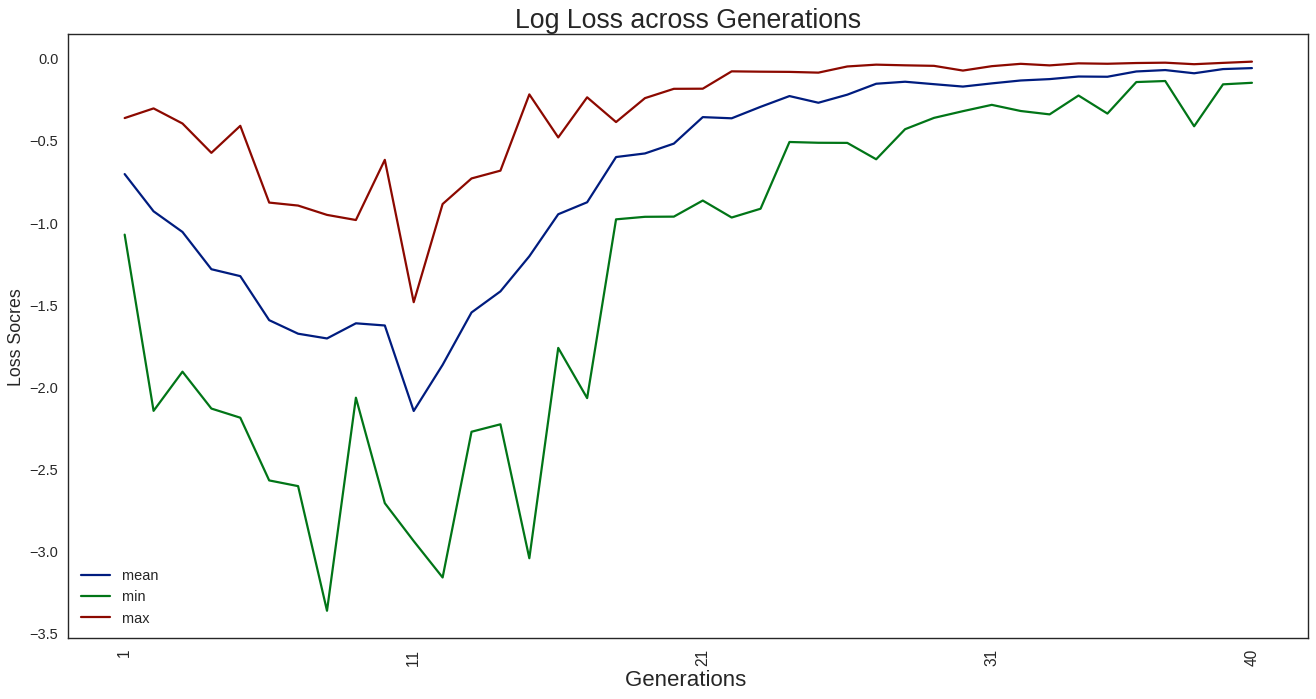

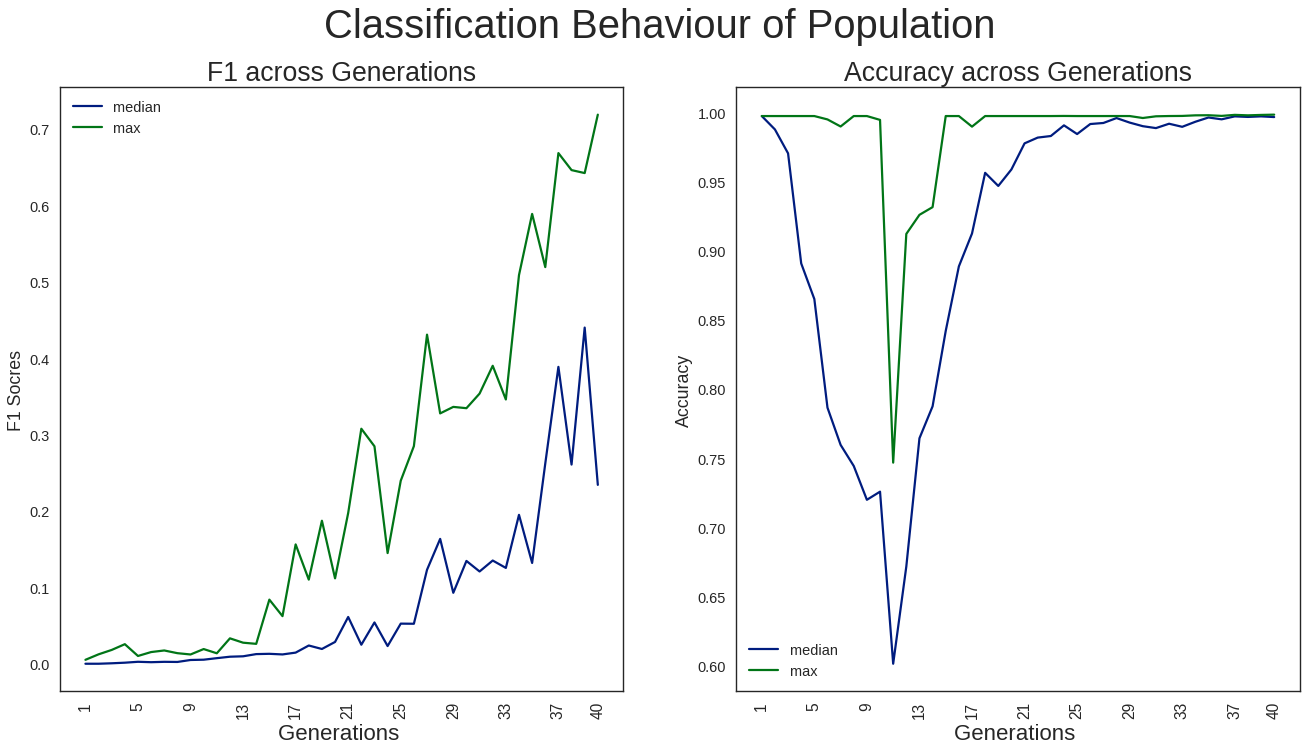

In [0]:
# 
rl_lrarnings = learnings
rl_history = []
[rl_history.extend(i[3]) for i in learnings if len(i) !=0]
len(rl_history),np.array(rl_history).shape
plot_learning(rl_history)

#### We had good training . Now checking on validation set

Loading model from file: /content/gdrive/My Drive/RELM/rl_test_1_rl_2_70000_21_50_40.json
Train Accuracy: 0.999
Train AUC: 0.9196992481203007
Train F1 Score: 0.8076923076923077
Train Confusion Matrix:
[[69783    42]
 [   28   147]]
Test Accuracy: 0.9992375
Test AUC: 0.7922977705675193
Test F1 Score: 0.6934673366834171
Test Confusion Matrix:
[[79870    12]
 [   49    69]]


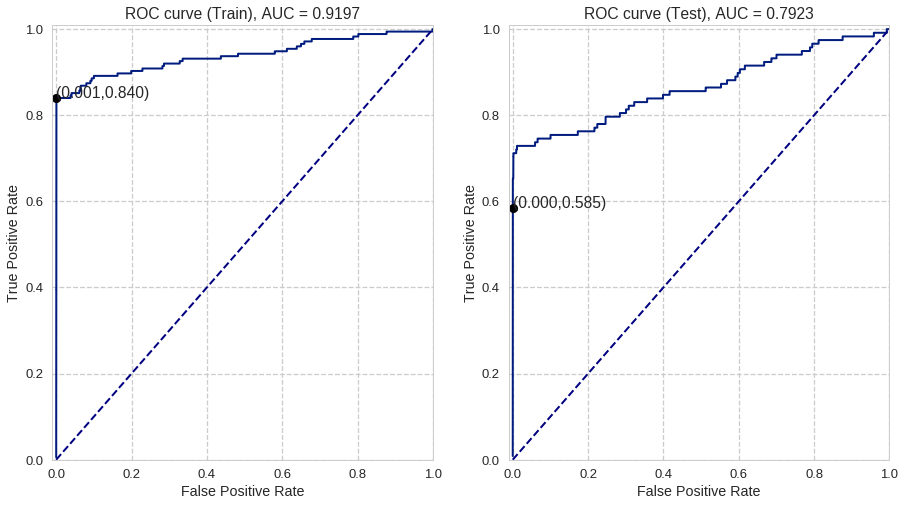

0.9112632078336823

In [0]:
# plotting on ROC on new data and checking new f1 and accuracy scores
model = Model().load_model('/content/gdrive/My Drive/RELM/rl_test_1_rl_2_70000_21_50_40.json')
population = ModelPopulation().load_population('/content/gdrive/My Drive/RELM/rl_test_1_rl_2_population_70000_21_50.json')
y_t, y_p, y_p_b = evaluate(X[:70000],y[:70000],model,0.9)
df_pred_train = pd.DataFrame({'y_true':y_t.flatten(),'y_pred':y_p.flatten(),'y_pred_binary':y_p_b.flatten()})

y_t, y_p, y_p_b = evaluate(X[70000:150000],y[70000:150000],model,0.9)
df_pred_test = pd.DataFrame({'y_true':y_t.flatten(),'y_pred':y_p.flatten(),'y_pred_binary':y_p_b.flatten()})

plot_ROC(df_pred_train.y_true, df_pred_train.y_pred, df_pred_test.y_true, df_pred_test.y_pred ,threshold=0.9)

#### As we can see on the test the performance is not generalized and hence we need to put this algorithm to RELM EVALUATOR & SAMPLE GENERATION for incorporating data trend deveation...

### ADAPT to CONCEPT DRIFT


RUNNING version-2 of the RELM run

In [0]:
# new environment
envr = TheEnvironment('f1_score',sample_size=0.5)

# adding samples learnt by network initally
envr.new_data(X[:70000],y[:70000])

# adding new samples to be learnt by network initally
envr.new_data(X[70000:150000],y[70000:150000])

# loading solver for further processing
population = ModelPopulation().load_population('/content/gdrive/My Drive/RELM/rl_test_1_rl_1_population_70000_21_150.json')
NPARAMS = population.model.param_count
NPOPULATION = 21
MAX_ITERATION = 50
CUTOFF=0.9

# solver initialition
cmaes = CMAES(NPARAMS,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = 0.5
          )

(10_w,21)-aCMA-ES (mu_w=6.2,w_1=27%) in dimension 2098 (seed=367347, Tue Nov 27 10:22:30 2018)


In [0]:
# checking how much data left
envr.action_space(test_old=True).shape

(115000, 28)

In [0]:
rl_lrarnings = learnings
rl_history = []
[rl_history.extend(i[3]) for i in learnings_2 if len(i) !=0]
len(rl_history),np.array(rl_history).shape

NameError: ignored

In [0]:
# is warn  =True means second time learning
population_2, learnings_2 = reinforced_learning(envr=envr, population=population, solver=cmaes, 
                                            obj_func=objective, learning_iterations=MAX_ITERATION,
                                            name='paper_rl', problem='binaryclass', select_k=5,
                                            threshold = 8, num_episodes = 10, sample_size =  0.7, num_iterations = 10, is_warm=True)


Running Episode: 1 Action Space: (80000, 28)
Rewards for Episode are: 6.758620689655173 Individual values: [0.6758620689655173, 0.6758620689655173, 0.6758620689655173, 0.6758620689655173, 0.6758620689655173, 0.6758620689655173, 0.6758620689655173, 0.6758620689655173, 0.6758620689655173, 0.6758620689655173]

Making agent learn form the new data!
Data Size: (115000, 28) True Positives: 206
Population filled with [ 5  0  8  6 18  5  0  8  6 18  5  0  8  6 18  5  0  8  6 18  5]
Evoluting for newer generation!
Scorers for the experiment are: ['f1_score', 'accuracy', 'loss', 'cohen_kappa']
Iteration:   1 Time:  57 secs has fitness:   0.8154 f1_score:  0.6590 accuracy:  0.9987 loss:  0.0405 cohen_kappa:  0.6584


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration:   2 Time:  56 secs has fitness:   0.8154 f1_score:  0.6040 accuracy:  0.9986 loss:  0.0639 cohen_kappa:  0.6033
Iteration:   3 Time:  56 secs has fitness:   0.8154 f1_score:  0.6746 accuracy:  0.9988 loss:  0.0983 cohen_kappa:  0.6740
Iteration:   4 Time:  56 secs has fitness:   0.8154 f1_score:  0.5326 accuracy:  0.9984 loss:  0.0505 cohen_kappa:  0.5319
Iteration:   5 Time:  56 secs has fitness:   0.8154 f1_score:  0.5714 accuracy:  0.9986 loss:  0.0355 cohen_kappa:  0.5707
Iteration:   6 Time:  56 secs has fitness:   0.8154 f1_score:  0.4746 accuracy:  0.9977 loss:  0.0645 cohen_kappa:  0.4735
Iteration:   7 Time:  57 secs has fitness:   0.8154 f1_score:  0.6281 accuracy:  0.9987 loss:  0.0431 cohen_kappa:  0.6275
Iteration:   8 Time:  56 secs has fitness:   0.8154 f1_score:  0.6704 accuracy:  0.9990 loss:  0.0556 cohen_kappa:  0.6699
Iteration:   9 Time:  57 secs has fitness:   0.8154 f1_score:  0.6790 accuracy:  0.9989 loss:  0.0979 cohen_kappa:  0.6785
New best solutio

KeyboardInterrupt: ignored

In [0]:
population_2

len(learnings_2),[len(i) for i in learnings_2]
rl_lrarnings = learnings_2
rl_history = []
[rl_history.extend(i[3]) for i in learnings_2 if len(i) !=0]
len(rl_history),np.array(rl_history).shape
plot_learning(rl_history)

In [0]:
#generating latent features
latent_space, latent_dim, encoder = vae_feature_generation_3stg(X[:70000,:], components='values', funnel=(25,20,15), batch=1000, epoch=200)

In [0]:
from .environment import TheEnvironment,RELMEvaluator
from .feature_generators import vae_feature_generation_3stg
from .utils import plot_learning,plot_ROC,plot_pair
from .model_population import ModelParam,Model,ModelPopulation
from .relm_agent import RELMAgent

# RELM FIAL VERSION

In [0]:
training = cma_train
# training[3] = training[3][:150]
old_tr = cma_train[3][:150]
print(len(old_tr))
print(len(rl_history))
old_tr.extend(rl_history)
print(len(old_tr))